# Download United States region files for use as region presets in VEDA UI

Using 2023 "cartographic" shapes at 1:20 million resolution from https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html

In [1]:
import io
import zipfile
import tempfile
from pathlib import Path

import requests
import geopandas as gpd

# Contiguous United States

Download the US nation boundary from Census.gov and clip it to the Contiguous (Conterminous) United States

Remove small islands (< 2e9 sqm ~ 45000 sqkm) and simplify the US all-territories geometry 

In [2]:
CB_US_NATION_URL = "https://www2.census.gov/geo/tiger/GENZ2023/shp/cb_2023_us_nation_20m.zip"

In [3]:
CONUS_BOX = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -127.07908337441414,
              49.39780545464822
            ],
            [
              -127.07908337441414,
              23.116939555234325
            ],
            [
              -65.544580589319,
              23.116939555234325
            ],
            [
              -65.544580589319,
              49.39780545464822
            ],
            [
              -127.07908337441414,
              49.39780545464822
            ]
          ]
        ]
      }
    }
  ]
}

In [4]:
conus_box = gpd.GeoDataFrame.from_features(CONUS_BOX, crs="epsg:4326")

In [5]:
def gdf_from_shp_zip_url(zip_url):
    
    with tempfile.TemporaryDirectory() as tmpdir:
        r = requests.get(zip_url)
        r.raise_for_status()
        
        with zipfile.ZipFile(io.BytesIO(r.content)) as z:
            z.extractall(tmpdir)
        
        shp = next(Path(tmpdir).glob("*.shp"))
        return gpd.read_file(shp)

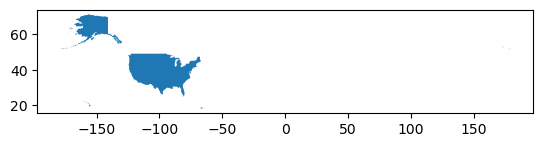

In [6]:
us_nation = gdf_from_shp_zip_url(CB_US_NATION_URL)
us_nation.plot();

In [7]:
def remove_small_rings(gdf, area_threshold_sqm):
    exploded = gdf.explode(index_parts=False)
    area = exploded.geometry.to_crs("epsg:6933").area
    return exploded[area >= area_threshold_sqm].dissolve()


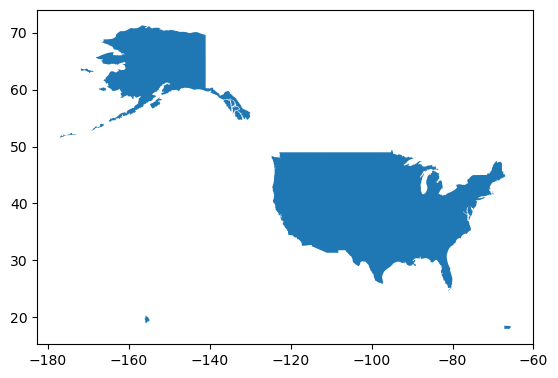

In [8]:
us_nation_filtered = remove_small_rings(us_nation, area_threshold_sqm=2e9)
us_nation_filtered.plot() ;

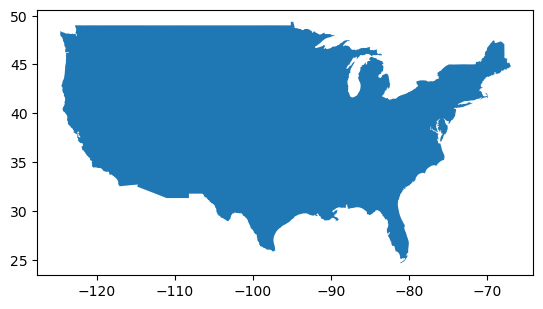

In [9]:
us_conus = us_nation_filtered.intersection(conus_box.to_crs(us_nation_filtered.crs))
us_conus.plot() ;

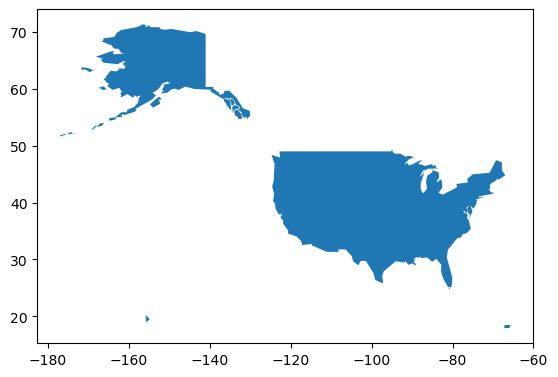

In [10]:
us_nation_final = gpd.GeoDataFrame(geometry=us_nation_filtered.simplify(0.2))
us_nation_final.plot() ;

In [11]:
def to_geojson_file(gdf, path):
    nice_geojson = gdf.to_json(to_wgs84=True, drop_id=True)
    with Path(path).open("w") as f:
        f.write(nice_geojson)

In [12]:
path = Path("states") / "United States (Contiguous).geojson"
path.parent.mkdir(exist_ok=True)
to_geojson_file(gpd.GeoDataFrame(geometry=us_conus), path)

path = Path("states") / "United States.geojson"
path.parent.mkdir(exist_ok=True)

to_geojson_file(us_nation_final.drop(columns=list(set(us_nation_final) - {"geometry"})), path)

# States

Download the states regions and save each state to its own GeoJSON file

For Alaska, filter out small islands and simplify the geometry to avoid https://github.com/NASA-IMPACT/veda-ui/issues/923

In [13]:
CB_US_STATES_URL = "https://www2.census.gov/geo/tiger/GENZ2023/shp/cb_2023_us_state_20m.zip"

In [14]:
us_states = gdf_from_shp_zip_url(CB_US_STATES_URL)

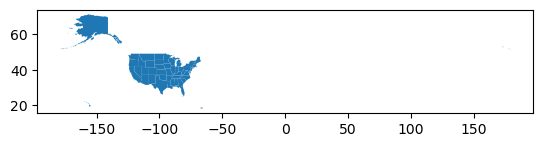

In [15]:
us_states.plot() ;

In [16]:
for i in range(len(us_states)):
    state = us_states.iloc[[i]]
    state_name = state.iloc[0]['NAME']
    path = Path("states") / f"{state_name}.geojson"

    if state_name == "Alaska":
        state = remove_small_rings(state, 2e9)
        state = gpd.GeoDataFrame(geometry=state.simplify(0.2))
    
    state = state.drop(columns=list(set(state) - {"geometry"}))
    path.parent.mkdir(exist_ok=True)
    to_geojson_file(state, path)

In [17]:
state.geometry.__geo_interface__

{'type': 'FeatureCollection',
 'features': [{'id': '51',
   'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': (((-114.799683, 32.593621),
      (-114.809393, 32.617119),
      (-114.76495, 32.649391),
      (-114.719633, 32.718763),
      (-114.705717, 32.741581),
      (-114.667493, 32.734226),
      (-114.615724877807, 32.7412791646992),
      (-114.570675, 32.747417),
      (-114.540260338478, 32.7748291815141),
      (-114.531746, 32.782503),
      (-114.468971, 32.845155),
      (-114.463127, 32.901884),
      (-114.47664, 32.923628),
      (-114.481315, 32.972064),
      (-114.511343, 33.023455),
      (-114.517492069319, 33.0247159744928),
      (-114.575161, 33.036542),
      (-114.628293, 33.031052),
      (-114.670803, 33.037984),
      (-114.706175, 33.105335),
      (-114.679359, 33.159519),
      (-114.678097, 33.2303),
      (-114.674491, 33.255597),
      (-114.723259, 33.288079),
      (-114.707962, 33.323421),
      (-114.707

In [18]:
print("\"" + "\",\n\"".join(sorted(us_states["NAME"].values)) + "\"")

"Alabama",
"Alaska",
"Arizona",
"Arkansas",
"California",
"Colorado",
"Connecticut",
"Delaware",
"District of Columbia",
"Florida",
"Georgia",
"Hawaii",
"Idaho",
"Illinois",
"Indiana",
"Iowa",
"Kansas",
"Kentucky",
"Louisiana",
"Maine",
"Maryland",
"Massachusetts",
"Michigan",
"Minnesota",
"Mississippi",
"Missouri",
"Montana",
"Nebraska",
"Nevada",
"New Hampshire",
"New Jersey",
"New Mexico",
"New York",
"North Carolina",
"North Dakota",
"Ohio",
"Oklahoma",
"Oregon",
"Pennsylvania",
"Puerto Rico",
"Rhode Island",
"South Carolina",
"South Dakota",
"Tennessee",
"Texas",
"Utah",
"Vermont",
"Virginia",
"Washington",
"West Virginia",
"Wisconsin",
"Wyoming"
